## Pt 1 - Thefuzz

In [19]:
# imports 
import pandas as pd
from thefuzz import process

# load data
path = '/Users/Marcy_Student/Desktop/clean_full_collisions.csv'
df = pd.read_csv(path)


In [20]:
vehicle_cols = ['vehicle_type_code_1','vehicle_type_code_2','vehicle_type_code_3',
                'vehicle_type_code_4','vehicle_type_code_5']


unique_vehicles = pd.unique(df[vehicle_cols].values.ravel()) # makes 1-dimensional and only takes each value once

unique_vehicles = sorted([v for v in unique_vehicles if pd.notna(v)]) # sorted list without missing values

unique_vehicles # displays all unique vehicle types in the dataset. helps to preview before making categories

['-',
 '.',
 '0',
 '000',
 '0000',
 '09',
 '10 Paaseng',
 '100th truc',
 '12 PASSENG',
 '13',
 '16m',
 '17',
 '18 WHEELER',
 '18 wheeler',
 '2',
 '2 dr sedan',
 '2 wheel sc',
 '263',
 '2YDSWHEELL',
 '3 Wheel Sc',
 '3 Wheel Ve',
 '3-Door',
 '325FLCR',
 '340AJ',
 '4',
 '4 dr sedan',
 '4 wheeler',
 '4door',
 '4dsd',
 '5',
 '50CC SCOOT',
 '50cc mini',
 '7',
 '787',
 '997',
 '999',
 'A',
 'A bulance',
 'A,n',
 'ABMU',
 'ABULANCE',
 'ACCESS A R',
 'ACCESS RID',
 'ACCESS-ARI',
 'ACUR',
 'ALL TERRAI',
 'AMAZON TRU',
 'AMAZON VAN',
 'AMB',
 'AMBALANCE',
 'AMBLUANCE',
 'AMBU',
 'AMBULACE',
 'AMBULANCE',
 'AMBULANCE`',
 'AMBULANE',
 'AMBULANVE',
 'AMBULENCE',
 'AMBULETTE',
 'AMSGC',
 'AMULANCE',
 'APP',
 'APPORTIONE',
 'ARCIMOTO',
 'ARMORED TR',
 'ASPHALT RO',
 'ATTECHMENT',
 'AUTOTRLR T',
 'Access A R',
 'Access a R',
 'Access-A-R',
 'All-Terrain Vehicle',
 'Amazon Van',
 'Amazon del',
 'Amazon tru',
 'Amazon van',
 'Amb',
 'Ambu',
 'Ambulance',
 'Ambulances',
 'Ambulence',
 'Ambulette',
 'Appor

In [21]:
motor_categories = [ # list of motor vehicle categories to fuzzymatch
    "Sedan", "SUV", "Taxi", "Pickup Truck", "Van", "Truck", "Bus",
    "Motorcycle", "Moped", "Scooter", "Ambulance", "Fire Truck",
    "Garbage Truck", "Delivery Truck", "Forklift / Construction",
    "Trailer", "Government Vehicle", "Commercial Vehicle", "Unknown"
]


In [22]:
def detect_government(raw):
    if not isinstance(raw, str):
        return None

    s = raw.lower()

    gov_keywords = [
        "fdny", "nypd", "usps", "postal", "mta", "dot",
        "city", "nyc", "ems", "sanitation",
        "gov", "government", "parks", "transit"
    ]

    # if any keyword matches, return a label
    if any(k in s for k in gov_keywords):
        return "Government Vehicle"

    return None


In [23]:
def fuzzy_motor_class(raw): # function to match motor catagories
    if not isinstance(raw, str): # if the input is not a string, return Unknown
        return "Unknown"
    clean = raw.strip() # remove leading and trailing whitespace

    match, score = process.extractOne(clean, motor_categories) # returns motor catagory if match score is high enough

    
    return match if score >= 70 else "Unknown" # adjust threshold depending on how wild the data is


In [24]:
def classify_government(raw):
    gov = detect_government(raw)
    if gov is not None:
        return gov

    return fuzzy_motor_class(raw)
    
df["VEHICLE CLEAN"] = df["VEHICLES COMBINED"].apply(classify_government)


Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  |  |  |']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '|  | 

In [25]:
df['VEHICLES COMBINED'] = df[vehicle_cols].fillna('').agg(' | '.join, axis=1) 
# fills missing values with an empty space, then combines vehicle type columns into one string per row. makes it easier to run fuzzy matching
#  or electric detection on all vehicles in the crash at once, instead of checking each column individually. **IMPORTANT** technically losing data because it puts
# all vehicle types into one string, but for this analysis it's acceptable(Note as constraint).






In [26]:

df["VEHICLE CLEAN"].value_counts()

VEHICLE CLEAN
Sedan                      158693
Government Vehicle         152556
Unknown                     15403
Pickup Truck                14157
Taxi                         7135
Truck                        6297
Motorcycle                   4029
Scooter                      3208
Bus                          2561
Ambulance                    1625
Van                          1543
Moped                        1417
Garbage Truck                 813
Delivery Truck                138
Fire Truck                    124
Trailer                       120
SUV                            93
Forklift / Construction        56
Commercial Vehicle             33
Name: count, dtype: int64

In [27]:
government_categories = [
    "Government Vehicle",
    "Fire Truck",
    "Ambulance",
    "Bus",          # MTA / public buses
    "Garbage Truck",
    "Delivery Truck"  # USPS, city delivery
]


df["is_government"] = df["VEHICLE CLEAN"].apply(lambda x: 1 if x in government_categories else 0)


print(df["is_government"].value_counts())
print(f'\n',df["is_government"].value_counts(normalize=True))

is_government
0    212184
1    157817
Name: count, dtype: int64

 is_government
0    0.573469
1    0.426531
Name: proportion, dtype: float64


In [28]:
# crashes with at least one electric vehicle
government_crashes = df[df["is_government"] == 1]

# total injured and killed
total_injured = government_crashes["number_of_persons_injured"].sum()
total_killed = government_crashes["number_of_persons_killed"].sum()
# crashes where no one was injured or killed
no_injury_crashes = government_crashes[
    (government_crashes["number_of_persons_injured"] == 0) &
    (government_crashes["number_of_persons_killed"] == 0)]

total_no_injury_crashes = no_injury_crashes.shape[0]

print(f"Total persons injured in government vehicle crashes: {total_injured}")
print(f"Total persons killed in government vehicle crashes: {total_killed}")
print(f"Number of government vehicle crashes with no injury or death: {total_no_injury_crashes}")
print(f"Total people affected by vehicle crashes: {total_injured + total_killed+ total_no_injury_crashes}")


Total persons injured in government vehicle crashes: 88938
Total persons killed in government vehicle crashes: 384
Number of government vehicle crashes with no injury or death: 95305
Total people affected by vehicle crashes: 184627


In [29]:
factor_cols = [
    "contributing_factor_vehicle_1",
    "contributing_factor_vehicle_2",
    "contributing_factor_vehicle_3",
    "contributing_factor_vehicle_4",
    "contributing_factor_vehicle_5"
]

# filter to government vehicle crashes
gov_crashes = df[df["is_government"] == 1]

# stack contributing factors into one column
gov_factors = gov_crashes[factor_cols].stack()

# clean missing values
gov_factors = gov_factors[gov_factors.notna() & (gov_factors != "")]

# count contributing factors
gov_factors.value_counts()

Unspecified                                              169504
Driver Inattention/Distraction                            47387
Following Too Closely                                     13498
Failure to Yield Right-of-Way                             12257
Passing or Lane Usage Improper                             7886
Other Vehicular                                            7562
Unsafe Speed                                               6973
Passing Too Closely                                        5886
Traffic Control Disregarded                                5381
Backing Unsafely                                           5337
Turning Improperly                                         3832
Unsafe Lane Changing                                       3678
Alcohol Involvement                                        3678
Driver Inexperience                                        3675
Reaction to Uninvolved Vehicle                             2463
View Obstructed/Limited                 

## Pt 2 Time

/var/folders/_z/410cfm6x4fl_4m_6s41fnf4w0000gp/T/ipykernel_16663/4235172043.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_injuries.index, y=season_injuries.values, palette='viridis')


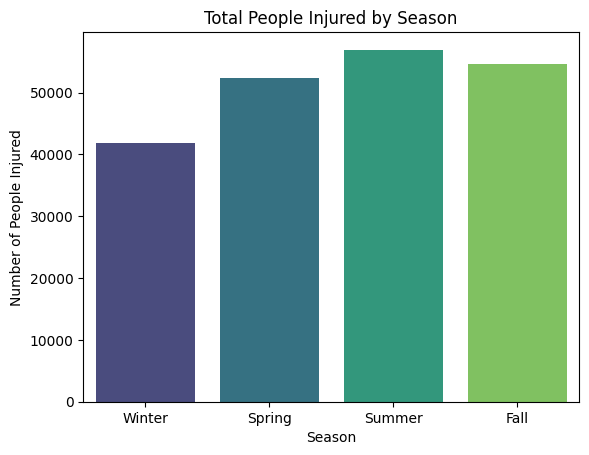

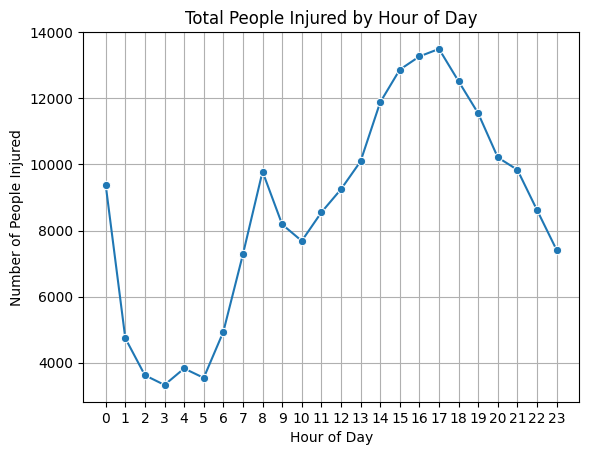

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



df['crash_date'] = pd.to_datetime(df['crash_date'], errors='coerce')


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['crash_date'].dt.month.apply(get_season)


season_injuries = df.groupby('season')['number_of_persons_injured'].sum().reindex(['Winter','Spring','Summer','Fall'])


sns.barplot(x=season_injuries.index, y=season_injuries.values, palette='viridis')
plt.title('Total People Injured by Season')
plt.ylabel('Number of People Injured')
plt.xlabel('Season')
plt.show()


hour_injuries = df.groupby('crash_time')['number_of_persons_injured'].sum()



sns.lineplot(x=hour_injuries.index, y=hour_injuries.values, marker='o')
plt.title('Total People Injured by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of People Injured')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

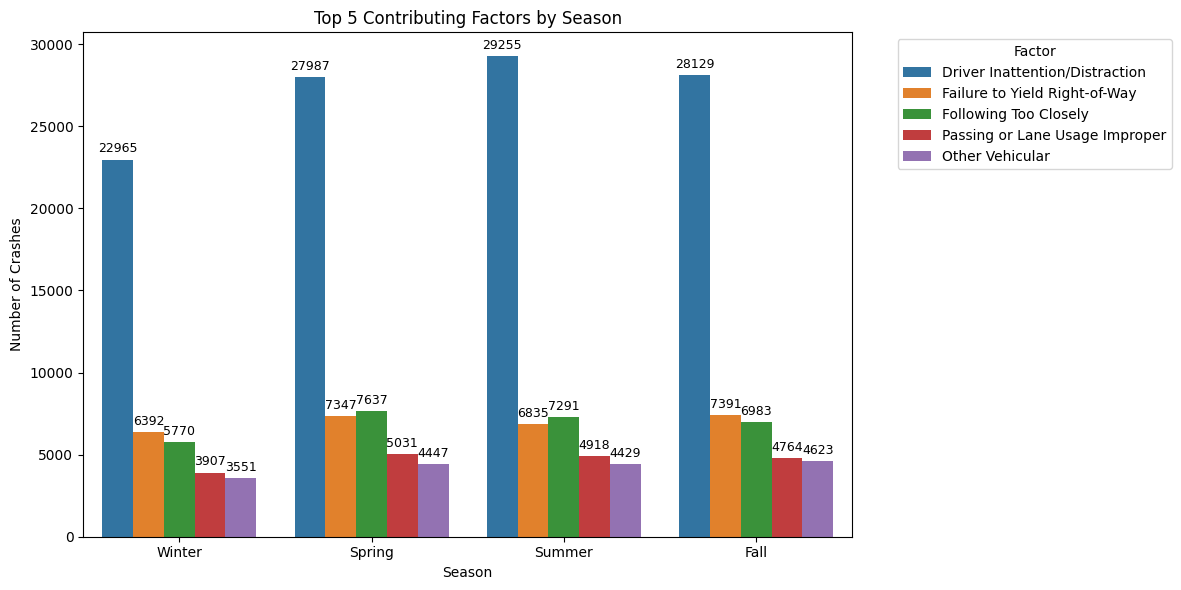

In [60]:
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='season', 
    y='count', 
    hue='contributing_factor', 
    data=top_factors
)

# Bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(),
    by_label.keys(),
    title='Factor',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.title('Top 5 Contributing Factors by Season')
plt.ylabel('Number of Crashes')
plt.xlabel('Season')
plt.tight_layout()
plt.show()
